# Alzheimer’s Disease and Cognitive Impairment Prediction
**ELIUD OMOLLO**<br/>

In [1]:
#numpy and pandas
import pandas as pd
import numpy as np

In [2]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [4]:
#Regressions
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [5]:
#classification
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

In [6]:
#Regression model metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [7]:
#classification metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [8]:
#regularization 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA

In [9]:
#cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [10]:
#utilities
from sklearn.model_selection import train_test_split

In [11]:
#global random state
rnd_state = 41

In [12]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

**FUNCTIONS**<br/>

**Imputing Functions**

In [13]:
#impute missing numerical data with mean
def imputeWithMean(dataFrame):
    nullCols = dataFrame.columns[dataFrame.isnull().any()].tolist()
    for col in nullCols:        
        col_mean = dataFrame[col].mean()
        dataFrame[col] = dataFrame[col].fillna(col_mean)
    return dataFrame

In [14]:
#We will add new columns that tracks changes from the baseline data
#if there is no change, function will record zero, otherwise function will record 1

def trackBaseline(dataFrame):
    #check if a baseline col exists
    blColArray  = []
    for col in list(dataFrame):
        if '_bl' in col:
            blColArray.append(col)
        else:
            blCol = col+'_bl'            
            if blCol in list(dataFrame):                
                #create a new column and populate the column with 0 if no change, 1 if there is a change
                f = lambda x: 1 if x[col] != x[blCol] else 0
                #create a new cols with the new values                              
                dataFrame[col+'_chg'] = dataFrame.apply(f, axis = 1)
    #drop all the baseline columns
    dataFrame = dataFrame.drop(blColArray, axis=1)
    return dataFrame

**Encoding Function**

In [15]:
#function to encode categorical data: 
# Target will be encoded with label encoding
#Features will be encoded using one hot encoding for features

def encodeData(dataFrame, target):
    catCols = []    
    #encode the target
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    dataFrame[target] =  le.fit_transform(dataFrame[target])
    cat = le.inverse_transform([0, 1, 2])
    
    #encode features
    feat = [x for x in list(dataFrame) if x !=target]
    for col in feat:
        if dataFrame[col].dtype.kind == 'O': 
            catCols.append(col)
    catDf = dataFrame[catCols]
    catDf_en = pd.get_dummies(catDf, drop_first= True)
    
    dataFrame = dataFrame.drop(catCols, axis= 1)    
    dataFrame = pd.concat([dataFrame, catDf_en], axis=1)
    return dataFrame, cat

**Standardize Data function**

In [16]:
#function to standardize the the test and train data using the mean and std of the train 
def dataScaler(train, test, target):
    
    features = [x for x in list(train) if (x !=target)]    
    mean = np.mean(train.loc[:, features])    
    std = np.std(train.loc[:, features])
    f = lambda x: (x-mean)/std
    
    train_n = train.apply(f, axis = 1) 
    train_n[target] = train[target]
    
    test_n  = test.apply(f, axis = 1)
    test_n[target] = test[target]
    return train_n , test_n

**Model Evaluation**

In [17]:
#function to evaluate and plot various models

def modelAnalyzer(X_train, y_train, X_test, y_test):
    scores = {} 
    f1_scores = {}
    precision_scores = {}
    recall_scores = {}
   
    models = dict(
        lgr =LogisticRegressionCV(Cs=10, random_state=rnd_state, penalty='l2', cv = 5, multi_class='multinomial'),
        ld = LinearDiscriminantAnalysis(),
        qd =QuadraticDiscriminantAnalysis(),
        knn= KNeighborsClassifier(),
        rnd = RandomForestClassifier(random_state= rnd_state, max_depth=None, max_features='sqrt')
        )
    def fitpredict(model, suf):
        #fit data
        model.fit(X_train, y_train)

        #make predictions
        y_predict_train  = model.predict(X_train)
        y_predict_test  = model.predict(X_test)

        #store values
        #scores[name +'_train_score_' + str(suf)] = model.score(X_train, y_train)
        scores[name +'_test_score_' + str(suf)] = model.score(X_test, y_test)

        #calculate and store f1-scores
        #f1_scores[name +'_train_f1_' + str(suf)] = f1_score(y_train,y_predict_train, average='weighted')
        f1_scores[name +'_test_f1_' + str(suf)] = f1_score(y_test,y_predict_test, average='weighted')


        #calculate and store precision scores
        #precision_scores[name +'_train_precision_' + str(suf)] = precision_score(y_train,y_predict_train, average='weighted')
        precision_scores[name +'_test_precision_' + str(suf)] = precision_score(y_test,y_predict_test, average='weighted')

        #calculate and store recall scores
        #recall_scores[name +'_train_recall_' + str(suf)] = recall_score(y_test,y_predict_test, average='weighted')
        recall_scores[name +'_test_recall_' + str(suf)] = recall_score(y_test,y_predict_test, average='weighted')
        
    for name, model in models.items():        
        if name in ['lgr', 'ld', 'qd']:
            fitpredict(model, '')
        elif name in ['knn','rnd']:
            params = {}
            params['knn'] =  {'n_neighbors': [2, 5, 10, 20]}
            params['rnd'] = {'n_estimators': [5, 10, 20, 30, 40]}
            for key, paramDict in params.items():
                 for k, param in paramDict.items():
                        for item in param:
                            if name == key:
                                model = model.set_params(**{k: item})
                                suf = str(key) + '_' + str(item)
                                fitpredict(model, suf )   
        else:
            pass       
    scoresDF = pd.DataFrame.from_records([scores])
    f1_scoresDF = pd.DataFrame.from_records([f1_scores])
    pscoresDF = pd.DataFrame.from_records([precision_scores])
    rscoresDF = pd.DataFrame.from_records([recall_scores])    
    return scoresDF,  f1_scoresDF, pscoresDF , rscoresDF 

**Visualization Functions**

In [18]:
#Plot histogram given a dataframe and a colum. The histogram is colored by target type
def histPlot(dataFrame, col, grouby):
    plt.figure()
    grouped = dataFrame.groupby(grouby)
    colors = ['blue', 'red', 'green']
    
    for i, group in enumerate(grouped):
        plt.subplot(1,1, 1)        
        plt.hist(group[1][col], color=colors[i], label= group[1][grouby])
        plt.xlabel(col)
        plt.title(col + ' HISTOGRAM')
        plt.legend()   

In [19]:
#Plot scatter given a dataframe and a colum. The scatterplot is colored by target type
def scatterPlot(dataFrame, xcol, ycol, groupby):
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1,1.0, 1.0 ])
    colors = {0:'green', 1:'cyan', 2:'red', 3:'green', 4: 'magenta'}    
    categories = dataFrame.groupby(groupby)
    for key, category in categories:    
        category.plot(ax=ax, kind='scatter', x=xcol, y=ycol, label=key, color=colors[key])        
    ax.set_title('Scatter plot of ' + xcol + ' vs ' + ycol)
    plt.show()    

In [20]:
#Function to plot missing data
def plotMissingData(dataFrame):
    miss_data = {col: (pd.isnull(dataFrame[col]).sum()/dataFrame.shape[0])*100 for col in list(dataFrame) }
    miss_data_df = pd.DataFrame.from_dict(data=miss_data, orient='index')
    g = sns.factorplot(x=miss_data_df.index , y=0, data=miss_data_df, kind= 'bar', aspect=4)
    g.set_xticklabels(rotation=90, fontsize=10)
    g.set_xlabels('Feature')
    g.set_ylabels('% of Missing data')
    plt.show()

In [21]:
#Plot collinearility
def plot_collinearity(df, cols):    
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    sns.heatmap(np.corrcoef(df.T), ax=ax)
    ax.set_xticklabels(cols, rotation='vertical')
    ax.set_yticklabels(cols[::-1], rotation='horizontal')
    plt.show()

**BASELINE MODEL**<br/>

<b>Import data and drop any unnecessary columns</b>

In [22]:
adnimergeDF= pd.read_csv('data\ADNIMERGE.csv')
#Drop those columns since they do not add value to the model or they present internal tracking data only
#for example, SITE is the location where the test was done or they are collinear
dropCols= ['PTID','VISCODE', 'SITE','COLPROT', 'ORIGPROT', 'EXAMDATE', 'FLDSTRENG', 'FSVERSION','EXAMDATE_bl',
           'FLDSTRENG_bl', 'FSVERSION_bl', 
            'Years_bl','Month','Month_bl' ,'M','update_stamp',
            'EcogPtMem', 'EcogPtLang',
            'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
            'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
            'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl',
            'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl',
            'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPPlan_bl',
            'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl',
            'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting','RAVLT_perc_forgetting', 'RAVLT_perc_forgetting',
            'RAVLT_immediate_bl','RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
            'ADAS11', 'ADAS13', 'ADAS11_bl', 'ADAS13_bl'
          ]
adnimergeDF= adnimergeDF.drop(dropCols, axis=1)

In [23]:
adnimergeDF.shape

(13017, 38)

In [24]:
adnimergeDF.columns

Index(['RID', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'MMSE', 'FAQ',
       'MOCA', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
       'Fusiform', 'MidTemp', 'ICV', 'DX', 'CDRSB_bl', 'MMSE_bl', 'FAQ_bl',
       'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl',
       'Fusiform_bl', 'MidTemp_bl', 'ICV_bl', 'MOCA_bl', 'FDG_bl', 'PIB_bl',
       'AV45_bl'],
      dtype='object')

<b>Plot missing data</b>

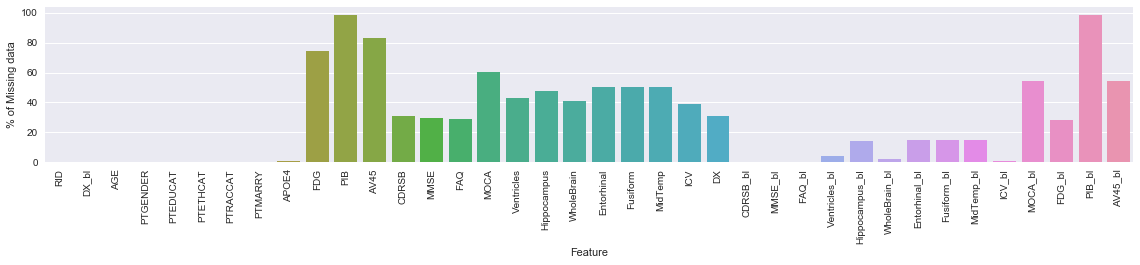

In [25]:
plotMissingData(adnimergeDF)

In [26]:
#We are going to rows with null values for Target data 'DX','DX_bl' 
adnimergeDF = adnimergeDF.dropna(subset=['DX','DX_bl'], axis=0, how='any')

<b>Impute missing data</b>

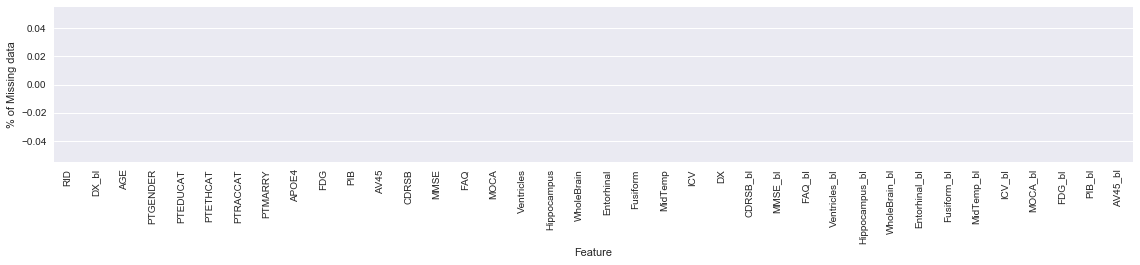

In [27]:
#impute and plot missing data using our functios
adnimergeDF = imputeWithMean(adnimergeDF)
#returns null. All missing data imputed
plotMissingData(adnimergeDF)

In [28]:
#Create a baseline change column using our function. Recal that the baseline function creates a new column
#that records 0 if no change occurred in the baseline and the current measurement, otherwise it records 1
blData_final  = trackBaseline(adnimergeDF)

In [29]:
#We now have new fields with the suffix "_chg". These fields contain 0 if no change from the baseline, 1 if there is change
blData_final.columns

Index(['RID', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY',
       'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'MMSE', 'FAQ', 'MOCA',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'DX', 'FDG_chg', 'PIB_chg', 'AV45_chg', 'CDRSB_chg',
       'MMSE_chg', 'FAQ_chg', 'MOCA_chg', 'Ventricles_chg', 'Hippocampus_chg',
       'WholeBrain_chg', 'Entorhinal_chg', 'Fusiform_chg', 'MidTemp_chg',
       'ICV_chg', 'DX_chg'],
      dtype='object')

<b>Perform one hot encoding on categorical data</b>

In [30]:
#Perform One hot encoding on categorical data using our function. Also does label encoding on target colums
blData_final, cat = encodeData(blData_final, 'DX')

In [31]:
#Display inverse encoding
print(cat)

['CN' 'Dementia' 'MCI']


In [32]:
#Our final data
blData_final.head()

,RID,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,MMSE,FAQ,...,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed
0,2,74.3,16,0.0,1.36926,1.781869,1.195086,0.0,28.0,0.0,...,0,0,0,0,0,1,1,0,0,0
1,3,81.3,18,1.0,1.09079,1.781869,1.195086,4.5,20.0,10.0,...,0,0,0,0,0,1,1,0,0,0
2,3,81.3,18,1.0,1.06360,1.781869,1.195086,6.0,24.0,12.0,...,0,0,0,0,0,1,1,0,0,0
3,3,81.3,18,1.0,1.10384,1.781869,1.195086,3.5,17.0,17.0,...,0,0,0,0,0,1,1,0,0,0
4,3,81.3,18,1.0,1.03871,1.781869,1.195086,8.0,19.0,14.0,...,0,0,0,0,0,1,1,0,0,0


In [33]:
blData_final.describe()

,RID,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,MMSE,FAQ,...,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed
count,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,...,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000
mean,2212.596857,73.747374,15.958361,0.544924,1.208160,1.781869,1.195086,2.107747,26.588149,5.455133,...,0.017733,0.040067,0.000561,0.008418,0.001347,0.930303,0.765769,0.030191,0.004153,0.118855
std,1859.793954,7.014481,2.837294,0.658405,0.098701,0.066626,0.111252,2.647046,3.945217,7.705160,...,0.131986,0.196128,0.023684,0.091365,0.036676,0.254650,0.423541,0.171122,0.064311,0.323636
min,2.000000,54.400000,4.000000,0.000000,0.636804,1.095000,0.814555,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,605.000000,69.500000,14.000000,0.000000,1.208160,1.781869,1.195086,0.000000,25.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1257.000000,73.700000,16.000000,0.000000,1.208160,1.781869,1.195086,1.000000,28.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,4335.000000,78.700000,18.000000,1.000000,1.208160,1.781869,1.195086,3.000000,29.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,5296.000000,91.400000,20.000000,2.000000,1.753320,2.927500,2.669210,18.000000,30.000000,30.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**BASELINE EXPLORATORY DATA ANALYSIS: OVERALL**<br/>: 

<b>Train/Test Split </b>

In [34]:
#Split the data into  75% train and 25% test splits
X = blData_final.drop('RID', axis = 1)
train, test = train_test_split(X, test_size=0.25, random_state=rnd_state)

Pie Chart of DX Distrubution


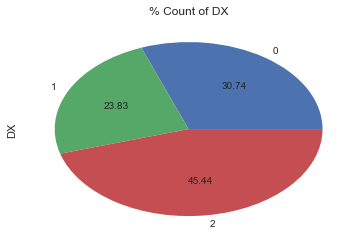

In [35]:
train['DX'].value_counts(sort=False).plot.pie(autopct='%.2f').set_title('% Count of DX')
print('Pie Chart of DX Distrubution')
plt.show()

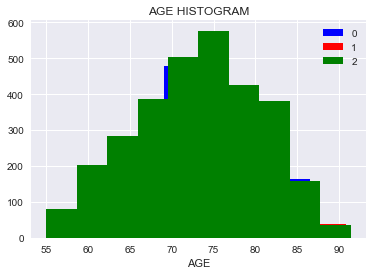

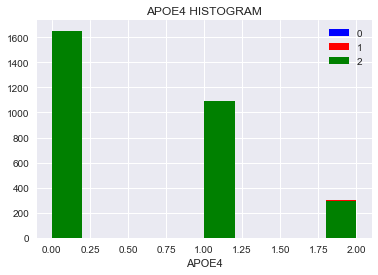

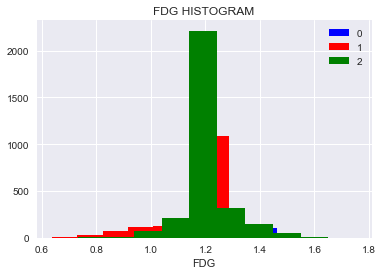

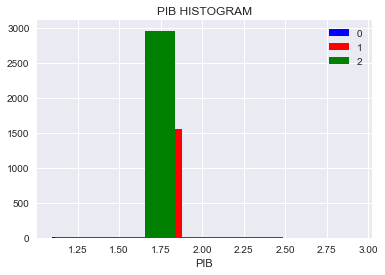

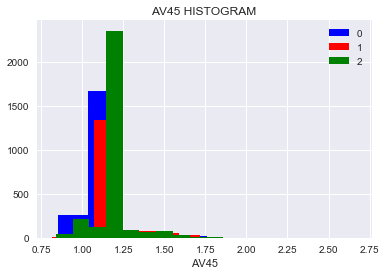

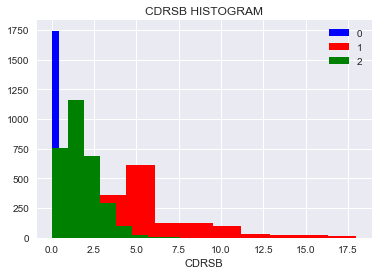

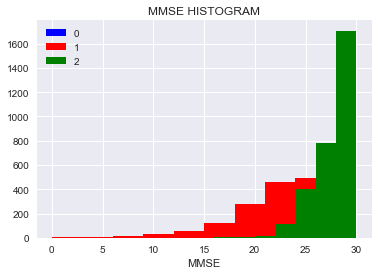

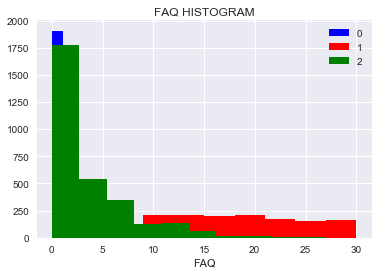

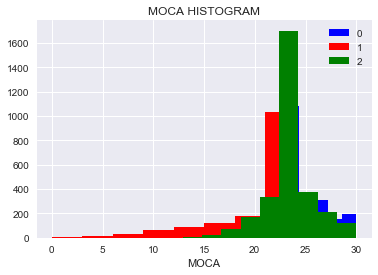

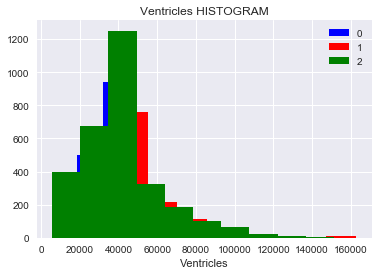

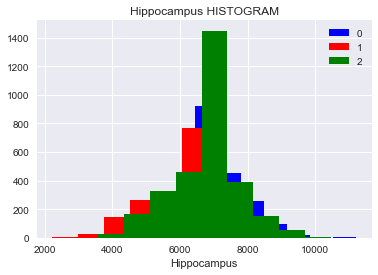

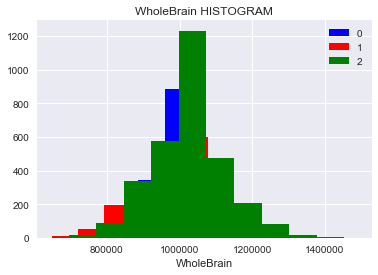

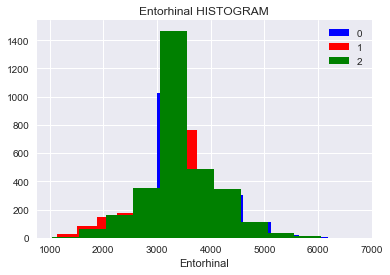

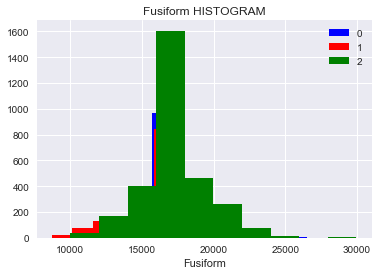

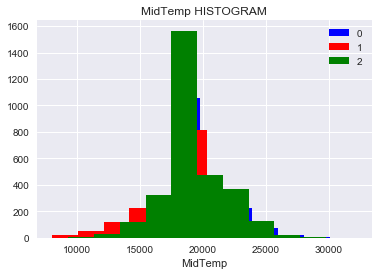

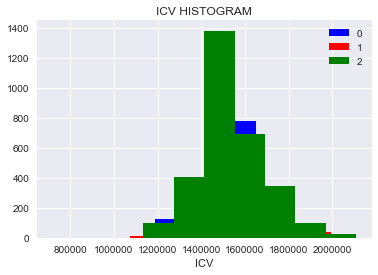

In [36]:
numCols = ['AGE','APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'MMSE', 'FAQ', 'MOCA',
           'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
           'MidTemp', 'ICV']
for col in numCols:
    histPlot(train, col, 'DX')

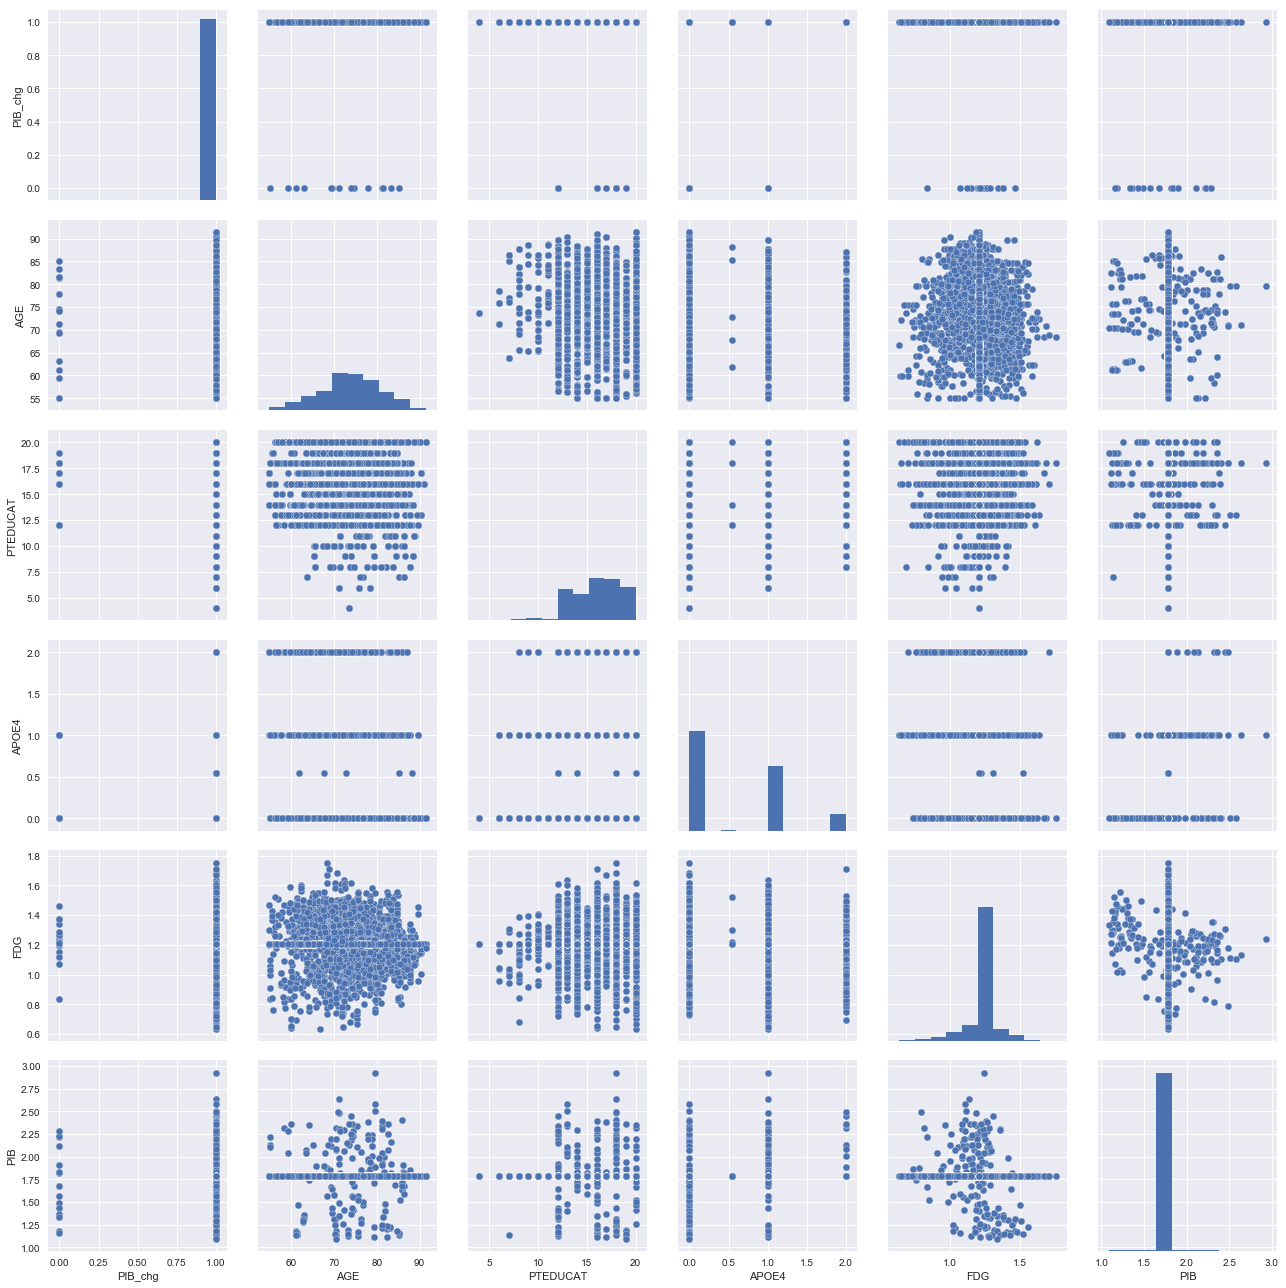

In [37]:
g = sns.pairplot(train.iloc[:, np.r_[19, 0:5]] ,palette='muted',size=3)

**BASELINE EXPLORATORY DATA ANALYSIS: COGNITIVE TESTS**<br/>: 

*<b>Cognitive Tests*</b>
<br>MMSE : Mini Mental State Exam
<br>FAQ: Functional Activities Questionnaire
<br>MOCA : Montreal Cognitive Assessment
<br>CDRSB : Clinical Dementia Rating

HISTOGRAM OF COGNITIVE TESTS


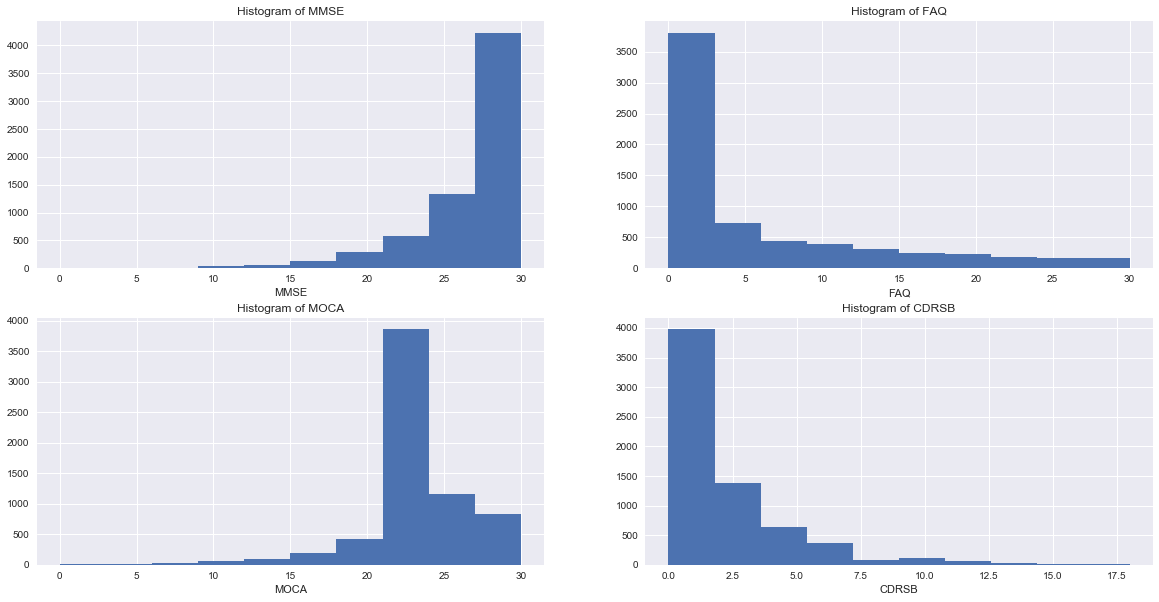

In [38]:
#Explanatory data analysis on Cognitive scores
cogCols = ['MMSE', 'FAQ', 'MOCA','CDRSB']
print('HISTOGRAM OF COGNITIVE TESTS')
plt.figure(figsize=(20, 10))
for k, p in enumerate(cogCols):
    plt.subplot(2,2, k+1)
    plt.xlabel(p)   
    plt.title('Histogram of ' + p)
    train[p].hist()
plt.show()

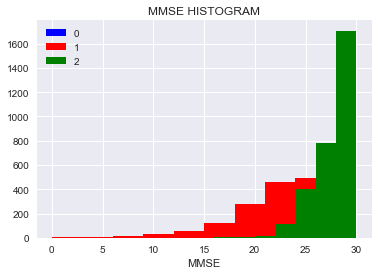

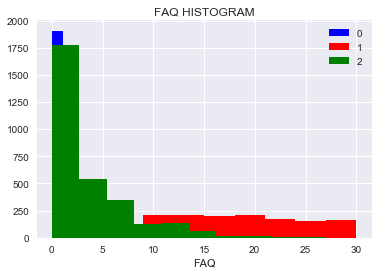

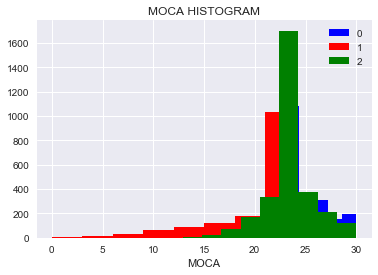

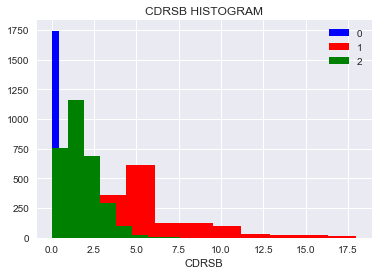

In [39]:
for i, col in enumerate(cogCols):    
    histPlot(train, col, 'DX')

Pie Chart of DX Distrubution


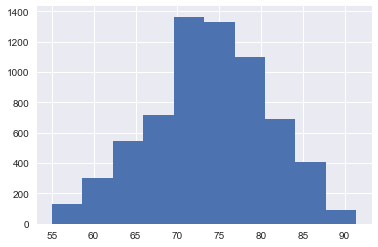

In [40]:
train['AGE'].hist()
print('Pie Chart of DX Distrubution')
plt.show()

['CN' 'Dementia' 'MCI'] = [0, 1, 2]
From the histogram distribution, observe the following:
<br>1: MMSE: Subjects  with scores less than 17, had dimentia(encoded 1)
<br>2: MOCA: Subjects  with scores less than 15, had dimentia(encoded 1).
<br>3: FAQ: Subjects with scores greater than 28 had dimentia(encoded 1).
<br>4: CDRSB: Subjects with scores greater than 8 had dimentia(encoded 1).  
CDRSB Official Guidelines: Score
<br>0-18 --- Mild
<br>19-36 -- Moderate
<br>37-54 -- Severe


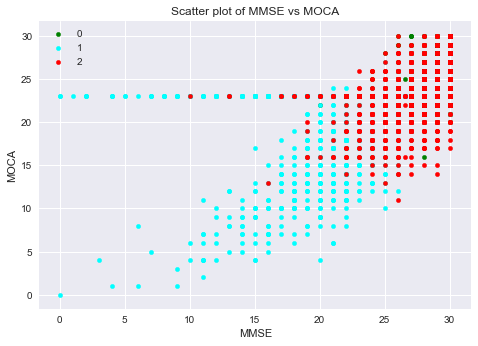

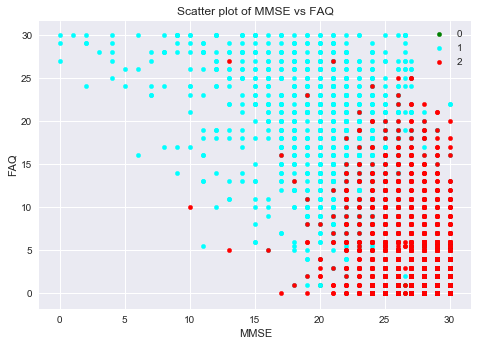

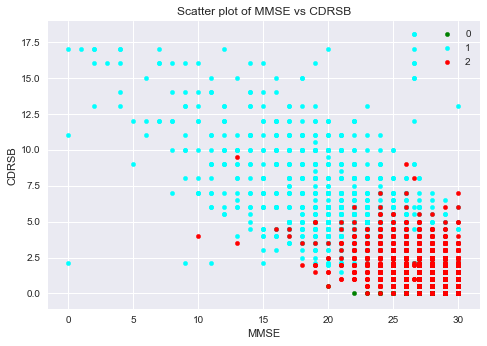

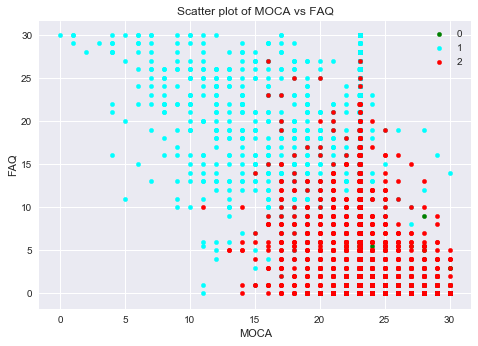

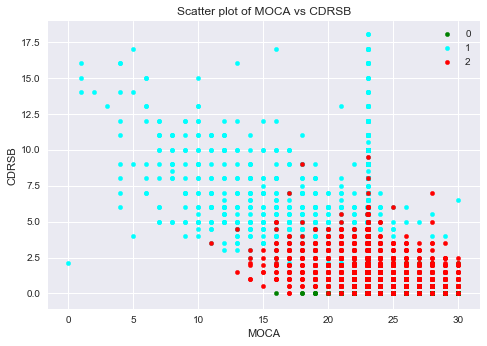

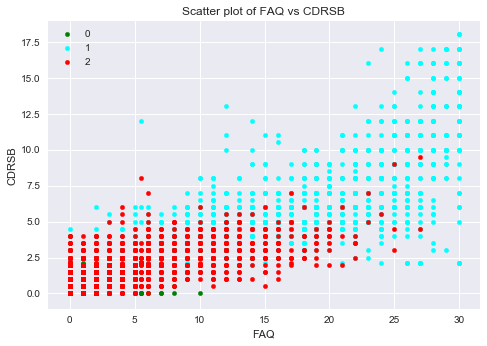

In [41]:
pairs = [('MMSE', 'MOCA'), ('MMSE', 'FAQ'), ('MMSE', 'CDRSB'), ('MOCA', 'FAQ'), ('MOCA', 'CDRSB'), ('FAQ', 'CDRSB')]
for k, p in enumerate(pairs):    
    scatterPlot(train, p[0], p[1], 'DX')

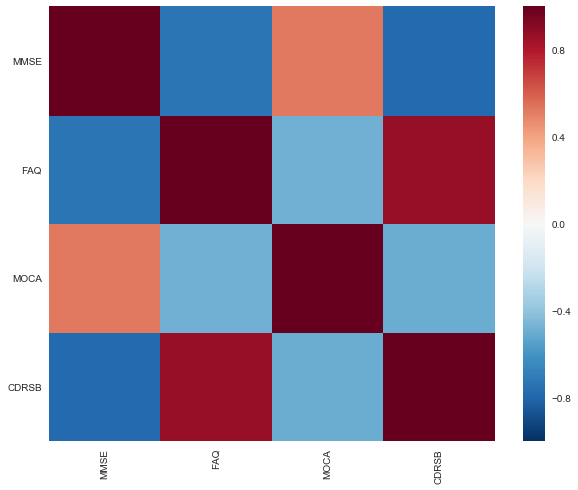

In [42]:
#We will use our function to plot collinearity
plot_collinearity(train[cogCols] , cogCols)

Observed collinearity: 
'MMSE', 'FAQ', 'MOCA','CDRSB'
Features without collinearity
<br>No collinearity: 'MMSE' with 'MOCA'
<br>No collinearity: 'FAQ' with 'MOCA'
<br>No collinearity: 'MOCA' with 'CDRSB', MMSE and 'FAQ'

**BASELINE PREDICTIONS**<br/>: 

In [43]:
#Use the custom function we created to standardize the data
#Recall we are standardizing the data using the mean and standard deviation of the train data
train, test = dataScaler(train, test, 'DX')

In [44]:
train.describe()

,AGE,APOE4,AV45,AV45_chg,CDRSB,CDRSB_chg,DX,DX_chg,Entorhinal,Entorhinal_chg,...,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,Ventricles,Ventricles_chg,WholeBrain,WholeBrain_chg
count,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6682.000000,6.682000e+03,6.682000e+03,6.682000e+03,...,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03,6.682000e+03
mean,5.908151e-14,1.719001e-16,4.585387e-13,2.606249e-16,-9.705230e-16,-1.465787e-16,1.146962,1.729635e-16,-2.669692e-13,-9.090803e-16,...,-1.095352e-16,-7.931565e-16,6.601451e-16,-9.981997e-16,3.414762e-16,3.537029e-16,3.503614e-14,-2.397231e-16,2.800835e-13,4.061070e-16
std,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,0.860384,1.000075e+00,1.000075e+00,1.000075e+00,...,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00
min,-2.670551e+00,-8.238791e-01,-3.398385e+00,-2.980707e+00,-7.941728e-01,-9.889861e-01,0.000000,-1.723453e+00,-3.630501e+00,-2.244133e+00,...,-1.323322e-01,-2.067826e-01,-2.736493e-02,-9.518774e-02,-3.238347e-02,-3.623099e+00,-1.802675e+00,-2.091818e+00,-3.613036e+00,-2.065324e+00
25%,-6.088465e-01,-8.238791e-01,-4.310785e-03,3.354909e-01,-7.941728e-01,-9.889861e-01,0.000000,-1.723453e+00,-3.076870e-01,4.456064e-01,...,-1.323322e-01,-2.067826e-01,-2.736493e-02,-9.518774e-02,-3.238347e-02,2.760068e-01,-6.465024e-01,4.780530e-01,-5.576452e-01,4.841855e-01
50%,2.555613e-03,-8.238791e-01,-4.310785e-03,3.354909e-01,-4.191118e-01,-9.889861e-01,1.000000,5.802304e-01,-1.367647e-03,4.456064e-01,...,-1.323322e-01,-2.067826e-01,-2.736493e-02,-9.518774e-02,-3.238347e-02,2.760068e-01,8.859585e-03,4.780530e-01,7.010017e-03,4.841855e-01
75%,7.134883e-01,6.928090e-01,-4.310785e-03,3.354909e-01,3.310104e-01,1.011137e+00,2.000000,5.802304e-01,4.179064e-01,4.456064e-01,...,-1.323322e-01,-2.067826e-01,-2.736493e-02,-9.518774e-02,-3.238347e-02,2.760068e-01,2.371158e-01,4.780530e-01,5.329672e-01,4.841855e-01
max,2.505039e+00,2.209497e+00,1.314385e+01,3.354909e-01,5.956927e+00,1.011137e+00,2.000000,5.802304e-01,4.998999e+00,4.456064e-01,...,7.556742e+00,4.835996e+00,3.654313e+01,1.050555e+01,3.087995e+01,2.760068e-01,5.901576e+00,4.780530e-01,4.835135e+00,4.841855e-01


<b>Using Cognitive Test to determine Cognitive State</b>

In [45]:
#Use our model analyzer function evaluate the performance of each test
cogTests = ['MMSE', 'FAQ', 'MOCA','CDRSB']
cogScoresDF = {}
for cogTest in cogTests:    
    xx_train = train[cogTest].values.reshape(-1, 1)
    yy_train = train['DX']
    xx_test = test[cogTest].values.reshape(-1, 1)
    yy_test = test['DX']
    cogScoresDF[cogTest] = modelAnalyzer(xx_train,yy_train, xx_test, yy_test )

In [46]:
mm= cogScoresDF['MMSE'][0].T
fq= cogScoresDF['FAQ'][0].T
mo = cogScoresDF['MOCA'][0].T
cd = cogScoresDF['CDRSB'][0].T

In [47]:
mm

,0
knn_test_score_knn_10,0.633303
knn_test_score_knn_2,0.535009
knn_test_score_knn_20,0.622980
knn_test_score_knn_5,0.633303
ld_test_score_,0.572262
lgr_test_score_,0.640036
qd_test_score_,0.631508
rnd_test_score_rnd_10,0.642280
rnd_test_score_rnd_20,0.641831
rnd_test_score_rnd_30,0.641831


In [48]:
mm_f1 = cogScoresDF['MMSE'][1].T
fq_f1 = cogScoresDF['FAQ'][1].T
mo_f1 = cogScoresDF['MOCA'][1].T
cd_f1  = cogScoresDF['CDRSB'][1].T

In [49]:
cd_f1

,0
knn_test_f1_knn_10,0.845661
knn_test_f1_knn_2,0.609434
knn_test_f1_knn_20,0.863338
knn_test_f1_knn_5,0.863338
ld_test_f1_,0.851588
lgr_test_f1_,0.863338
qd_test_f1_,0.801292
rnd_test_f1_rnd_10,0.862402
rnd_test_f1_rnd_20,0.863338
rnd_test_f1_rnd_30,0.863338


In [50]:
mm_r = cogScoresDF['MMSE'][2].T
fq_r = cogScoresDF['FAQ'][2].T
mo_r = cogScoresDF['MOCA'][2].T
cd_r  = cogScoresDF['CDRSB'][2].T

In [51]:
cd_r

,0
knn_test_precision_knn_10,0.848751
knn_test_precision_knn_2,0.750116
knn_test_precision_knn_20,0.872471
knn_test_precision_knn_5,0.872471
ld_test_precision_,0.870294
lgr_test_precision_,0.872471
qd_test_precision_,0.814605
rnd_test_precision_rnd_10,0.871759
rnd_test_precision_rnd_20,0.872471
rnd_test_precision_rnd_30,0.872471


**Effect of Combining all cognitive scores together

In [52]:
#New we look at the effect of combining all scores together
#Use our model analyzer function evaluate the performance of each test
#define input and target
X_train_acog = train[['MMSE', 'FAQ', 'MOCA','CDRSB']]
y_train_acog = train['DX']
X_test_acog = test[['MMSE', 'FAQ', 'MOCA','CDRSB']]
y_test_acog = test['DX']

#User our model analyzer function to generate values
scoresDF,  f1_scoresDF, pscoresDF , rscoresDF  = modelAnalyzer(X_train_acog, y_train_acog, X_test_acog, y_test_acog)

In [53]:
scoresDF.T

,0
knn_test_score_knn_10,0.864004
knn_test_score_knn_2,0.806104
knn_test_score_knn_20,0.864452
knn_test_score_knn_5,0.857720
ld_test_score_,0.761221
lgr_test_score_,0.850987
qd_test_score_,0.792190
rnd_test_score_rnd_10,0.847397
rnd_test_score_rnd_20,0.850987
rnd_test_score_rnd_30,0.852334


In [54]:
f1_scoresDF.T

,0
knn_test_f1_knn_10,0.864290
knn_test_f1_knn_2,0.803608
knn_test_f1_knn_20,0.864698
knn_test_f1_knn_5,0.857966
ld_test_f1_,0.757529
lgr_test_f1_,0.850739
qd_test_f1_,0.790886
rnd_test_f1_rnd_10,0.847768
rnd_test_f1_rnd_20,0.851300
rnd_test_f1_rnd_30,0.852600


In [55]:
pscoresDF.T

,0
knn_test_precision_knn_10,0.866368
knn_test_precision_knn_2,0.811765
knn_test_precision_knn_20,0.866041
knn_test_precision_knn_5,0.859841
ld_test_precision_,0.792176
lgr_test_precision_,0.851895
qd_test_precision_,0.798219
rnd_test_precision_rnd_10,0.849616
rnd_test_precision_rnd_20,0.852613
rnd_test_precision_rnd_30,0.853933


In [56]:
rscoresDF.T

,0
knn_test_recall_knn_10,0.864004
knn_test_recall_knn_2,0.806104
knn_test_recall_knn_20,0.864452
knn_test_recall_knn_5,0.857720
ld_test_recall_,0.761221
lgr_test_recall_,0.850987
qd_test_recall_,0.792190
rnd_test_recall_rnd_10,0.847397
rnd_test_recall_rnd_20,0.850987
rnd_test_recall_rnd_30,0.852334


**CHAPTER 2: Using ADNI MERGE to determine Cognitive State**

In [59]:
#We will use our custom function model analyzer
X_train_adni = train.drop('DX', axis=1)
y_train_adni = train['DX']
X_test_adni = test.drop('DX', axis=1)
y_test_adni = test['DX']

#User our model analyzer function to generate values
scoresDF_adni,  f1_scoresDF_adni, pscoresDF_adni , rscoresDF_adni  = modelAnalyzer(X_train_adni, y_train_adni, 
                                                                                   X_test_adni, y_test_adni)


C:\Users\EliudOmollo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [60]:
scoresDF_adni.T

,0
knn_test_score_knn_10,0.837074
knn_test_score_knn_2,0.791293
knn_test_score_knn_20,0.837971
knn_test_score_knn_5,0.830341
ld_test_score_,0.857720
lgr_test_score_,0.899461
qd_test_score_,0.490126
rnd_test_score_rnd_10,0.908438
rnd_test_score_rnd_20,0.912029
rnd_test_score_rnd_30,0.909336


In [61]:
f1_scoresDF_adni.T

,0
knn_test_f1_knn_10,0.836977
knn_test_f1_knn_2,0.788412
knn_test_f1_knn_20,0.837105
knn_test_f1_knn_5,0.829810
ld_test_f1_,0.857731
lgr_test_f1_,0.899278
qd_test_f1_,0.402712
rnd_test_f1_rnd_10,0.908779
rnd_test_f1_rnd_20,0.912271
rnd_test_f1_rnd_30,0.909533


In [62]:
pscoresDF_adni.T

,0
knn_test_precision_knn_10,0.841671
knn_test_precision_knn_2,0.800564
knn_test_precision_knn_20,0.848889
knn_test_precision_knn_5,0.836373
ld_test_precision_,0.873729
lgr_test_precision_,0.900618
qd_test_precision_,0.749065
rnd_test_precision_rnd_10,0.909358
rnd_test_precision_rnd_20,0.913245
rnd_test_precision_rnd_30,0.910662


In [63]:
rscoresDF_adni.T

,0
knn_test_recall_knn_10,0.837074
knn_test_recall_knn_2,0.791293
knn_test_recall_knn_20,0.837971
knn_test_recall_knn_5,0.830341
ld_test_recall_,0.857720
lgr_test_recall_,0.899461
qd_test_recall_,0.490126
rnd_test_recall_rnd_10,0.908438
rnd_test_recall_rnd_20,0.912029
rnd_test_recall_rnd_30,0.909336


**CHAPTER 2: EFFECT OF MERGING MEDICAL HISTORY**<br/>

In [64]:
#import Medical History
medHistDF_r = pd.read_csv('data\MEDHIST.csv', low_memory=False)

#We are going to add columns that add value to the predictions
medHistDF = medHistDF_r.iloc[: , np.r_[2, 10:37]]

In [65]:
#CHAPTER 
#Merge all the data into one dataframe
data = pd.merge(blData_final, medHistDF, on='RID', how='inner')
data.shape

(14170, 74)

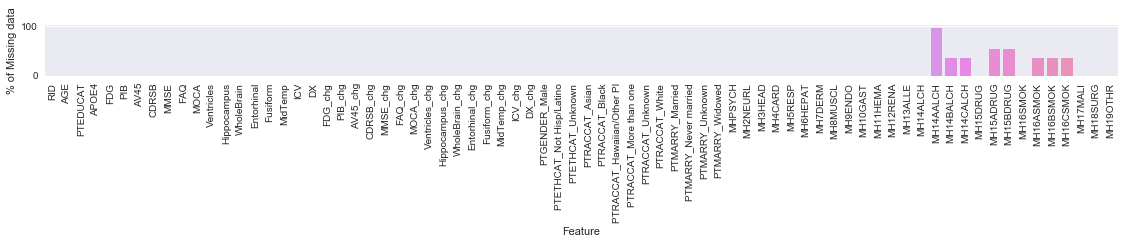

In [66]:
plotMissingData(data)

In [67]:
#impute the missing data

In [68]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=np.nan, strategy='mean', axis=1)
data_imp = pd.DataFrame(imp.fit_transform(data))
data_imp.columns = data.columns
data_imp.index = data.index

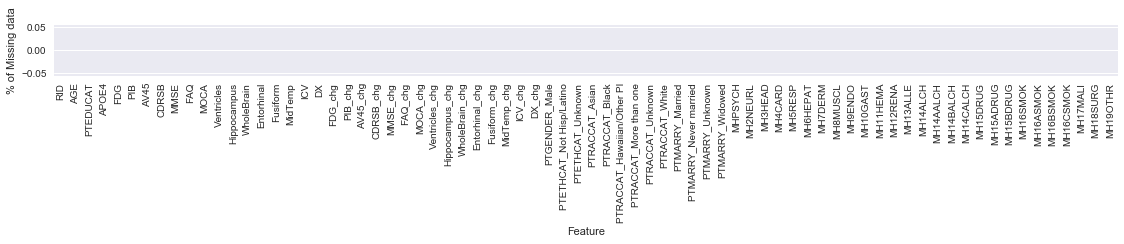

In [69]:
#confirm that no null values exist and all columns imputed using our function
plotMissingData(data_imp)

In [70]:
#Split the data into  75% train and 25% test splits
train, test = train_test_split(data_imp, test_size=0.25, random_state=rnd_state)

In [71]:
#Use the custom function we created to standardize the data
#Recall we are standardizing the data using the mean and standard deviation of the train data
train, test = dataScaler(train, test, 'DX')

In [72]:
train.describe()

,AGE,APOE4,AV45,AV45_chg,CDRSB,CDRSB_chg,DX,DX_chg,Entorhinal,Entorhinal_chg,...,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,RID,Ventricles,Ventricles_chg,WholeBrain,WholeBrain_chg
count,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,10627.000000,1.062700e+04,1.062700e+04,1.062700e+04,...,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04,1.062700e+04
mean,-6.059152e-14,4.487904e-16,-1.403934e-12,-3.163410e-17,-2.966031e-15,-1.141000e-15,1.137951,-6.353982e-17,-1.795240e-13,-1.159450e-15,...,-1.384044e-16,7.913036e-16,-4.953092e-16,4.990937e-16,-6.071908e-17,7.191847e-17,-8.706935e-14,-1.206024e-16,-7.464527e-14,-1.978280e-16
std,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,0.880908,1.000047e+00,1.000047e+00,1.000047e+00,...,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00
min,-2.892716e+00,-7.963365e-01,-3.566121e+00,-3.628958e+00,-7.556487e-01,-1.007841e+00,0.000000,-1.584165e+00,-3.673817e+00,-2.482146e+00,...,-2.018425e-01,-2.169611e-02,-8.872303e-02,-3.499711e-02,-3.717725e+00,-1.035877e+00,-1.812693e+00,-2.301221e+00,-3.675824e+00,-2.279584e+00
25%,-5.578285e-01,-7.963365e-01,9.347270e-03,2.755612e-01,-7.556487e-01,-1.007841e+00,0.000000,-1.584165e+00,-2.619824e-01,4.028771e-01,...,-2.018425e-01,-2.169611e-02,-8.872303e-02,-3.499711e-02,2.689817e-01,-7.349403e-01,-6.241777e-01,4.345520e-01,-5.409924e-01,4.386766e-01
50%,3.726774e-03,-7.963365e-01,9.347270e-03,2.755612e-01,-3.724458e-01,9.922200e-01,1.000000,6.312476e-01,-3.780520e-02,4.028771e-01,...,-2.018425e-01,-2.169611e-02,-8.872303e-02,-3.499711e-02,2.689817e-01,-4.159109e-01,1.579112e-02,4.345520e-01,1.194294e-02,4.386766e-01
75%,6.835042e-01,7.623756e-01,9.347270e-03,2.755612e-01,2.023585e-01,9.922200e-01,2.000000,6.312476e-01,4.127604e-01,4.028771e-01,...,-2.018425e-01,-2.169611e-02,-8.872303e-02,-3.499711e-02,2.689817e-01,3.696009e-01,1.955660e-01,4.345520e-01,5.125719e-01,4.386766e-01
max,2.575059e+00,2.321088e+00,1.386020e+01,2.755612e-01,6.142003e+00,9.922200e-01,2.000000,6.312476e-01,4.972039e+00,4.028771e-01,...,4.954359e+00,4.609121e+01,1.127103e+01,2.857379e+01,2.689817e-01,2.156226e+00,5.977688e+00,4.345520e-01,4.593523e+00,4.386766e-01


In [73]:
#using our custom model analyzer to evaluate function

X_train_comp = train.drop('DX', axis=1)
y_train_comp = train['DX']
X_test_comp = test.drop('DX', axis=1)
y_test_comp = test['DX']

#Applying our model analyzer
scores_comp,  f1_scores_comp, pscores_comp , rscores_comp  =  modelAnalyzer(X_train_comp, y_train_comp,X_test_comp,  y_test_comp)

C:\Users\EliudOmollo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\EliudOmollo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [74]:
scores_comp.T

,0
knn_test_score_knn_10,0.842224
knn_test_score_knn_2,0.842506
knn_test_score_knn_20,0.847587
knn_test_score_knn_5,0.843635
ld_test_score_,0.886255
lgr_test_score_,0.914197
qd_test_score_,0.497036
rnd_test_score_rnd_10,0.947502
rnd_test_score_rnd_20,0.951454
rnd_test_score_rnd_30,0.953712


In [75]:
f1_scores_comp.T

,0
knn_test_f1_knn_10,0.841609
knn_test_f1_knn_2,0.841319
knn_test_f1_knn_20,0.845893
knn_test_f1_knn_5,0.842657
ld_test_f1_,0.886308
lgr_test_f1_,0.914307
qd_test_f1_,0.414943
rnd_test_f1_rnd_10,0.947614
rnd_test_f1_rnd_20,0.951416
rnd_test_f1_rnd_30,0.953648


In [76]:
pscores_comp.T

,0
knn_test_precision_knn_10,0.841499
knn_test_precision_knn_2,0.851224
knn_test_precision_knn_20,0.850936
knn_test_precision_knn_5,0.843563
ld_test_precision_,0.896598
lgr_test_precision_,0.915399
qd_test_precision_,0.780897
rnd_test_precision_rnd_10,0.947801
rnd_test_precision_rnd_20,0.951697
rnd_test_precision_rnd_30,0.954241


In [77]:
rscores_comp.T

,0
knn_test_recall_knn_10,0.842224
knn_test_recall_knn_2,0.842506
knn_test_recall_knn_20,0.847587
knn_test_recall_knn_5,0.843635
ld_test_recall_,0.886255
lgr_test_recall_,0.914197
qd_test_recall_,0.497036
rnd_test_recall_rnd_10,0.947502
rnd_test_recall_rnd_20,0.951454
rnd_test_recall_rnd_30,0.953712
